<a href="https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/MicroBit_Onshape_Digital_Twin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Onshape Digital Twin with Microbit

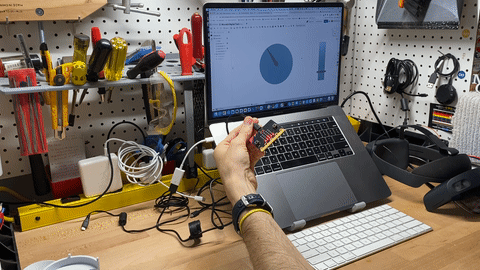

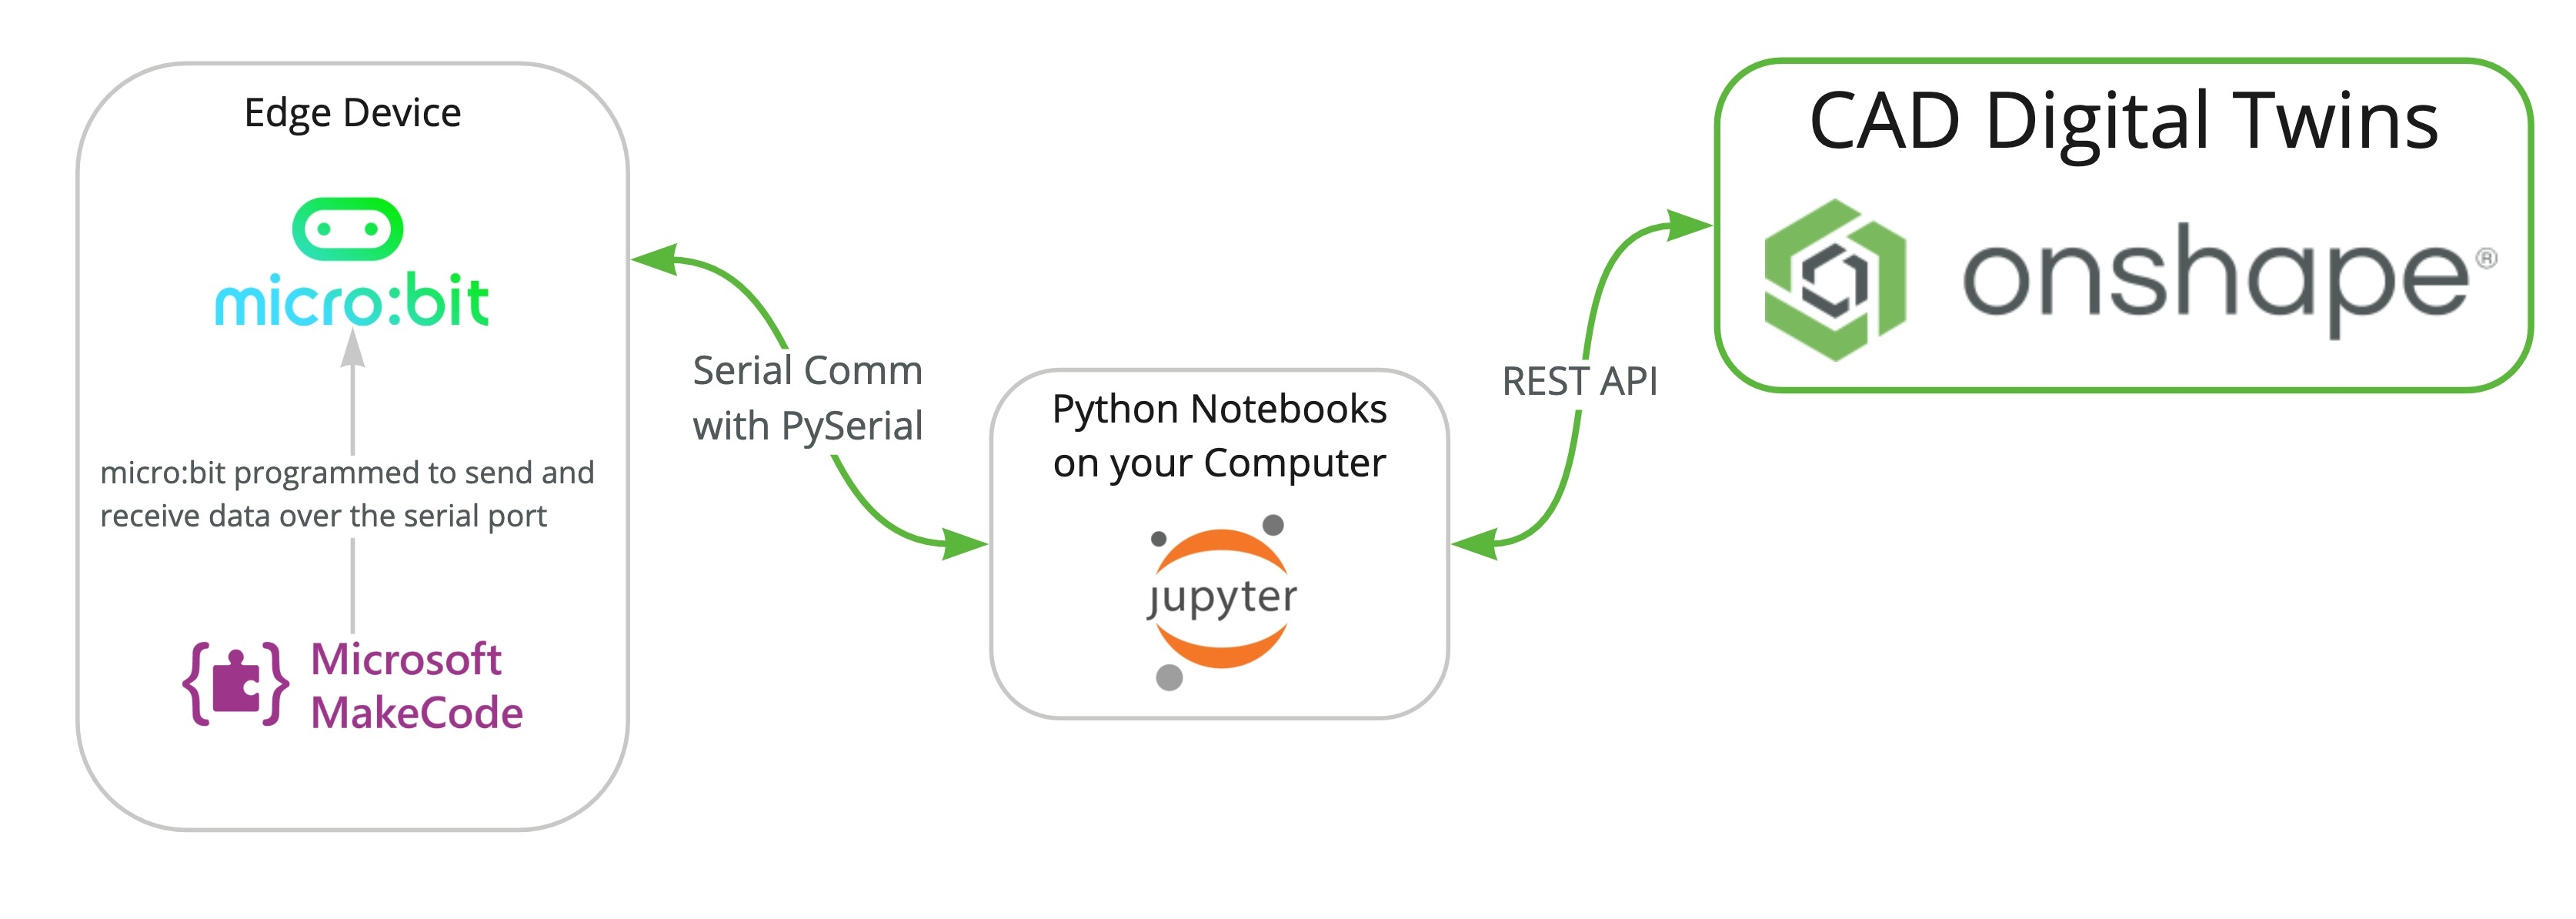

## Setup Process


1.   Follow [this hello world video](https://www.youtube.com/watch?v=LJ-vz1op80M) for getting set up with Onshape's REST API
2.   [Install Jupyter Notebooks](https://jupyter.org/install) on your computer and install necessary packages (see below)
3. Either configure Google Colab to run on your local Jupyter server with [these instructions](https://research.google.com/colaboratory/local-runtimes.html), or download this notebook and open it through Jupyter (i.e. open from http://localhost:8888 after starting Jupyter)
4. Download [this script](https://makecode.microbit.org/_LxJFbx4aWFxj) onto your Microbit, and make any chages to the serial communication
5. There are two demos in this notebook, one to rotate a model of a Microbit and another to simply monitor and control the Microbit (linked below). Make a copy of the public documents
6. Run the cells in this notebook in order, and make sure you change the DID, WID, and EID of the Onshape functions to match your new document

Links to Onshape documents and Microbit code are below.

* Public Onshape document of the Microbit [linked here](https://cad.onshape.com/documents/32703d124184c7b55761b09f/w/d7eb9109a3312be255719dc1/e/857afb03b2be711fe203dcbb)
* Public Onshape document of the monitor and control digital twin [linked here](https://cad.onshape.com/documents/130d56773425cc5e0bfd5fdb/w/6fe439a8e5ba9198f0b6e77e/e/c29d44772328ec3e4c5c9282)
* Microbit code for sending accelerometer values over the serial port [linked here](https://makecode.microbit.org/_LxJFbx4aWFxj). First download the code onto your Microbit, then unplug the microbit and close the webpage. **When connecting over serial, you may need to unplug and replug the Microbit until you see "True" from the cell with `ser.isOpen()`**

## Start Local Runtime

In order to connect to local devices, you will need to run Jupyter Notebooks locally on your computer. Follow [these instructions](https://jupyter.org/install) to get it installed.

You will also need to install a few python libraries on your computer for this notebook to work. [We recommend using pip](https://pip.pypa.io/en/stable/installation/) to install the packages, but any method will work.

### Install python packages

```
pip install pyserial
pip install onshape-client
pip install numpy
```

## Option 1: Connect Colab to Local Runtime

You can follow [these instructions](https://research.google.com/colaboratory/local-runtimes.html) for installing the jupyter http over web socket library and connecting Google Colab to your local runtime.

## Option 2: Download and Run through Jupyter

You can also download this notebook as a .ipynb file and open it through the jupyter notebooks interface (on the localhost:8888 web page)

## Import serial library and define functions

In [1]:
import serial
import sys
import glob
import time

def serial_ports():
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
        for port in ports:
            if 'usb' in port:
                guess = port
        return guess
    else:
        raise EnvironmentError('Unsupported platform')
    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return ports

def serial_write(string):
    ser.write(string + b'\r\n')
    time.sleep(0.1)
    while ser.in_waiting:  
        print(ser.read(ser.in_waiting).decode())
        

The code below should return "True" if the device is connected

In [4]:
port = serial_ports()
ser = serial.Serial(
    port=port,
    baudrate=9600
)

ser.isOpen()

True

Test serial connection

In [33]:
import time
ser.flushInput()
time.sleep(0.5)
for i in range(10):
  ser.reset_input_buffer()
  accelerometer = ser.readline().decode()
  # print(accelerometer)
  accelerometer = accelerometer.strip()
  try:
    print(accelerometer)
  except:
    print('serial communication error')
  
  time.sleep(1)

12,120,-1060,0
4,120,-1060,0
12,120,-1064,0
4,124,-1060,0
8,120,-1064,0
-40,184,-1064,1
-44,176,-1056,1
12,124,-1064,0
-4,120,-1056,0
8,132,-1064,0


### Define function for getting the accelerometer values into the correct range for the Onshape digital twin

In [5]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

## Import Onshape Client and configure with API Keys

In [6]:
!pip install onshape-client
from onshape_client.client import Client
import json
base = 'https://cad.onshape.com' # change this if you're using a document in an enterprise (i.e. "https://ptc.onshape.com")

Change filepath below to file with your keys. Should be of the form:
```
access = 'access-key-here'
secret = 'secret-key-here'
```

In [7]:
%run '~/Documents/colabkeys.py'
client = Client(configuration={"base_url": base,
                               "access_key": access,
                               "secret_key": secret})
print('client configured')

client configured


## Define Onshape Functions for Rotation Twin
First make a copy of one of the two documents below:

*   [Public Onshape document of the monitor and control digital twin](https://cad.onshape.com/documents/130d56773425cc5e0bfd5fdb/w/6fe439a8e5ba9198f0b6e77e/e/c29d44772328ec3e4c5c9282)
*   [Public Onshape document of the Microbit](https://cad.onshape.com/documents/32703d124184c7b55761b09f/w/d7eb9109a3312be255719dc1/e/857afb03b2be711fe203dcbb)


Make sure you update the DID, WID, and EID to the **assembly** of your Microbit digital twin.

### Matrix Library

In [8]:
import math
import numpy

def IdentitySixteen():
  m = [
      1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1
      ]
  return m

def DiceMove(value,x1,y1):
  matrix = DiceTransform(value)
  matrix[3] = x1
  matrix[7] = y1
  return matrix

def DiceFollow(diceMatrix,tcpMatrix):
  diceMatrix[3] = tcpMatrix[3]
  diceMatrix[7] = tcpMatrix[7]
  diceMatrix[11] = tcpMatrix[11]
  return diceMatrix
  
def sixteenToFourByFour(matrix):
  fourbyfour = [[matrix[0],matrix[1],matrix[2],matrix[3]],
                [matrix[4],matrix[5],matrix[6],matrix[7]],
                [matrix[8],matrix[9],matrix[10],matrix[11]],
                [matrix[12],matrix[13],matrix[14],matrix[15]]]
  return fourbyfour

def fourByFourToSixteen(matrix):
  sixteen = [matrix[0][0],matrix[0][1],matrix[0][2],matrix[0][3],
             matrix[1][0],matrix[1][1],matrix[1][2],matrix[1][3],
             matrix[2][0],matrix[2][1],matrix[2][2],matrix[2][3],
             matrix[3][0],matrix[3][1],matrix[3][2],matrix[3][3]]
  return sixteen

def clockwiseSpinX(theta):
  m = [[1, 0, 0, 0],
       [0, math.cos(theta), math.sin(theta), 0],
       [0, -math.sin(theta), math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinY(theta):
  m = [[math.cos(theta), 0, math.sin(theta), 0],
       [0, 1, 0, 0],
       [-math.sin(theta), 0, math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinZ(theta):
  m = [[math.cos(theta), math.sin(theta), 0, 0],
       [-math.sin(theta), math.cos(theta), 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]]
  return m

### Transform Onshape model function

In [9]:
def rotation(Rx,Ry,Rz):
  ## Get assembly occurances
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid'

  # https://cad.onshape.com/documents/32703d124184c7b55761b09f/w/d7eb9109a3312be255719dc1/e/857afb03b2be711fe203dcbb
  did = '32703d124184c7b55761b09f'
  wid = 'd7eb9109a3312be255719dc1'
  eid = '857afb03b2be711fe203dcbb'

  method = 'GET'

  params = {'includeNonSolids':True}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  fixed_url = fixed_url.replace('did', did)
  fixed_url = fixed_url.replace('wid', wid)
  fixed_url = fixed_url.replace('eid', eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
  # print(response.data)

  occurrences = json.loads(response.data)['rootAssembly']['occurrences']

  for x in occurrences:
      if x['path'][0] == 'MDO8kJV4gZ65wezUr':
        diceOccurrence = x
        print(diceOccurrence)

  # Translate object by x1,y1,z1 in the x,y,z directions
  mat = fourByFourToSixteen(numpy.matmul(clockwiseSpinY(Ry),clockwiseSpinX(Rx)))

  diceOccurrence['transform'] = mat

  ## Send assembly occurence transforms
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/occurrencetransforms'

  fixed_url = fixed_url.replace('did', did)
  fixed_url = fixed_url.replace('wid', wid)
  fixed_url = fixed_url.replace('eid', eid)

  method = 'POST'

  params = {}
  payload = {'isRelative':False,
            'occurrences':[diceOccurrence],
            'transform':mat}

  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)


In [ ]:
rotation(0.1,0.1,0)

{'transform': [0.9995294175010935, -0.004687023583746733, -0.030314606377962374, 0.0, 5.99563801384484e-17, 0.9882575677307416, -0.1527971852584434, 0.0, 0.030674803176636314, 0.15272528157717657, 0.9877925110149587, 0.0, 0.0, 0.0, 0.0, 1.0], 'fixed': False, 'hidden': False, 'path': ['MDO8kJV4gZ65wezUr']}


## Define functions for monitor control twin

In [ ]:
def GetSetMates(angle):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  
  ## CHANGE THE INFORMATION BELOW TO MATCH YOUR ONSHAPE URL
  # https://cad.onshape.com/documents/130d56773425cc5e0bfd5fdb/w/6fe439a8e5ba9198f0b6e77e/e/c29d44772328ec3e4c5c9282
  did = '130d56773425cc5e0bfd5fdb'
  wid = '6fe439a8e5ba9198f0b6e77e'
  eid = 'c29d44772328ec3e4c5c9282'

  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', did)
  fixed_url = fixed_url.replace('wid', wid)
  fixed_url = fixed_url.replace('eid', eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
  print(response.data)

  parsed = json.loads(response.data)
  slider = parsed['mateValues'][0]['translationZ']

  newMates = parsed

  newMates['mateValues'][1]['rotationZ'] = angle
  newMates['mateValues'].pop(0)
  # print(newMates)
  
  method = 'POST'

  params = {}
  payload = newMates
  headers = {'Accept': 'application/vnd.onshape.v2+json',
            'Content-Type': 'application/vnd.onshape.v2+json'}
  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  return slider

print(GetSetMates(-1))

# Main loop

### For monitor and control twin

In [ ]:
import time
import math

while True:
  ser.reset_input_buffer()
  accelerometer = ser.readline().decode()
  accelerometer = accelerometer.strip()
  # print(accelerometer)
  try:
    rx,ry,rz = accelerometer.split(',')
    radians = translate(int(rx),-1024,1024,-math.pi/2,math.pi/2)
    print('radians: '+str(radians))
    slider = GetSetMates(radians)
    val = translate(slider,0,-0.1,0,1)
    print('write val: '+str(val))
    serial_write(str(val).encode())
    time.sleep(0.5)
  except:
    print('serial communication error')
    time.sleep(0.3)

### For Microbit Rotation twin

In [ ]:
import time
while True:
  ser.reset_input_buffer()
  accelerometer = ser.readline().decode()
  accelerometer = accelerometer.strip()
  try:
    rx,ry,rz = accelerometer.split(',')
    print(rx,ry,rz)
    rz = int(rz)
    if rz < 1:
      OnshapeRY = translate(int(rx),-1024,1024,-math.pi/2,math.pi/2)
      OnshapeRX = translate(int(ry),-1024,1024,math.pi/2,-math.pi/2)
      print(OnshapeRX,OnshapeRY)
    elif rz > 1:
      OnshapeRY = translate(int(rx),-1024,1024,math.pi/2,3*math.pi/2)
      OnshapeRX = translate(int(ry),-1024,1024,-math.pi/2,math.pi/2)
      print(OnshapeRX,OnshapeRY)
    rotation(OnshapeRX,OnshapeRY,0)
  except:
    print('serial communication error')